In [21]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
from astropy.table import Table
import h5py
import tqdm
from scipy.interpolate import interp1d
import sys

In [3]:
allStarPath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits'
allStar = Table(fits.open(allStarPath)[1].data)

In [4]:
if True:
    allVisitPath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allVisit-dr17-synspec_rev1.fits' 
    allVisit = Table(fits.open(allVisitPath)[1].data)

In [5]:
CA_meta = Table(fits.open('../Data/230420_CAResiduals/CA_meta.fits')[1].data)
_, unique_inds = np.unique(CA_meta['FILE'], return_index = True)
CA_meta = CA_meta[unique_inds]
# CA_meta

In [6]:
# if 'ALLSTAR_IDX' not in CA_meta.keys():
allstarbools = np.zeros(len(allStar)).astype(bool)
if True:
    allStar_CA_idx = []
    for i in range(len(CA_meta)):
        row = CA_meta[i]
        idx = np.where(allStar['APOGEE_ID'] == row['APOGEE_ID'])[0]
        if len(idx) > 1:
            idx = idx[row['FIELD'] == allStar['FIELD'][idx]]
        allStar_CA_idx.append(idx.item())
        allstarbools[idx] = True
    CA_meta['ALLSTAR_IDX'] = np.array(allStar_CA_idx)
    try:
        CA_meta.write('../Data/230420_CAResiduals/CA_meta.fits', overwrite= False)
    except: pass

In [7]:
path_apMADGICS = '/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/mwm/sandbox/apMADGICS/'
vers0 = 'v2023_06_06/'
vers1 = 'v2023_07_24/'
idx_file = 'map2star_1indx'
idx_visit_file = 'map2visit_1indx'
outputsdir = 'outdir_wu/'
outputsdir_th = 'outdir_wu_th/'

# MADGICS README vers1 /uufs/chpc.utah.edu/common/home/sdss50/sdsswork/mwm/sandbox/apMADGICS/v2023_07_24/README.txt

def getoutputsdata(name, idx, version = vers0):
    if version == vers0: 
        outputs = outputsdir
    else:
        outputs = outputsdir_th
    with h5py.File(path_apMADGICS + version + outputs + 'apMADGICS_out_' + name + '.h5') as f:
        return f[name][idx]

with h5py.File(path_apMADGICS + vers0 + idx_file + '.h5') as f:
    idx0 = np.array(f[idx_file]) - 1

with h5py.File(path_apMADGICS + vers1 + idx_file + '.h5') as f:
    idx1 = np.array(f[idx_file]) - 1

with h5py.File(path_apMADGICS + vers0 + idx_visit_file + '.h5') as f:
    idxv0 = np.array(f[idx_visit_file]) - 1

print(np.all(idx0) == np.all(idx1)) #nice!

True


In [8]:
CAvidx = np.where(np.char.array(allVisit[idxv0]['FIELD']).startswith('CA_'))[0]
CA_visit = allVisit[idxv0[CAvidx]]

In [9]:
path_apMADGICS + vers0 + idx_visit_file + '.h5'

'/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/mwm/sandbox/apMADGICS/v2023_06_06/map2visit_1indx.h5'

In [10]:
CA_meta['APOGEE_ID', 'FILE']

APOGEE_ID,FILE
str30,str27
2M04044802+3829564,res_2M04044802+3829564.fits
2M04050513+3816512,res_2M04050513+3816512.fits
2M04051742+3813579,res_2M04051742+3813579.fits
2M04052072+3812344,res_2M04052072+3812344.fits
2M04052635+3901435,res_2M04052635+3901435.fits
2M04052920+3805548,res_2M04052920+3805548.fits
2M04053207+3835013,res_2M04053207+3835013.fits
2M04053346+3844571,res_2M04053346+3844571.fits
2M04053359+3810423,res_2M04053359+3810423.fits


In [11]:
### Testing ### 

def get_ca_res(fname):
    CAresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230420_CAResiduals/'
    return str(CAresdir + str(fname))


def get_madgics_res(fname):
    MADGICSresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230829_MADGICSResiduals/'
    return str(MADGICSresdir + str(fname))

mhdul = fits.open(get_madgics_res(CA_meta['FILE'][0]))

def get_wavs(hdulist = None, rv = 0):
    if hdulist is None:
        CRVAL1 = 4.179
        CDELT1 = 6e-06
        LEN = 8575
    else:
        header = hdulist[1].header
        CRVAL1 = header['CRVAL1']
        CDELT1 = header['CDELT1']
        LEN = header['NAXIS1']
        
    wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(LEN))
    wavs = wavs * (1 + rv / 3e5) # allows for shifting to observed frame from rest frame
    return wavs


wavs = get_wavs()
mwavs = get_wavs(hdulist = mhdul) #same from [125:]

def resample_interp(data, rv, resample_wavelengths = wavs, hdu_sel = None):
    wavs_rv = get_wavs(rv = rv, hdulist = hdu_sel)
    interp = interp1d(wavs_rv, data, kind = 'slinear', bounds_error = False)
    
    data_interp = interp(resample_wavelengths)
    
    return data_interp

def resample_interp_v2(data, rv, resample_wavelengths = mwavs):
    CDELT1 = 6e-06
    CRVAL1 = 4.179 - 125 * CDELT1
    LEN = 8700
    wavs_rv = np.power(10, CRVAL1 + CDELT1 * np.arange(LEN))
    wavs_rv = wavs_rv * (1 + rv / 3e5)
    interp = interp1d(wavs_rv, data, kind = 'slinear', bounds_error = False)
    
    data_interp = interp(resample_wavelengths)
    
    return data_interp

def resample_interp_madgics(data, rv_pix, resample_wavelengths = mwavs, hdu_sel = mhdul):
    DELT1 = 6e-06
    CRVAL1 = 4.179 - 125 * DELT1
    LEN = 8700
    wavs_rv = np.power(10, CRVAL1  + DELT1 * (np.arange(LEN) + rv_pix))

    interp = interp1d(wavs_rv, data, kind = 'slinear', bounds_error = False)
    
    data_interp = interp(resample_wavelengths)
    
    return data_interp

lambda0 = 15272.42

window = (wavs > lambda0 - 9) & (wavs < lambda0 + 9)
wavs_window = wavs[window]

mwindow = (mwavs > lambda0 - 9) & (mwavs < lambda0 + 9)
mwavs_window = mwavs[mwindow]

In [12]:
mrvelos = []
arvelos = []

for i in range(len(CA_meta)):
    star = CA_meta[i]
    v1 = star['ALLSTAR_IDX']
    match = np.where(idx0 == v1)[0]
    for j in match:
        mrvelos.append(getoutputsdata('RV_pixoff_final', j, version = vers0))
        arvelos.append(star['VHELIO_AVG'])

mrvelos = np.array(mrvelos)
arvelos = np.array(arvelos)

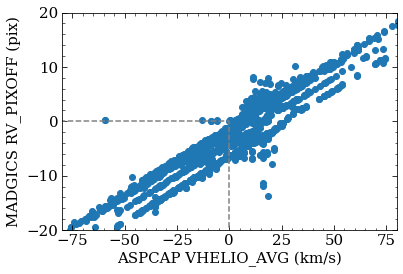

In [13]:
fig, ax = plt.subplots()

ax.scatter(arvelos, mrvelos)
ax.set_xlabel('ASPCAP VHELIO_AVG (km/s)')
ax.set_ylabel('MADGICS RV_PIXOFF (pix)')
ax.set_xlim(-80, 80)
ax.set_ylim(-20, 20)

plt.plot((-100, 0, 0), (0, 0, -40), linestyle = 'dashed', color = 'grey')

plt.show()

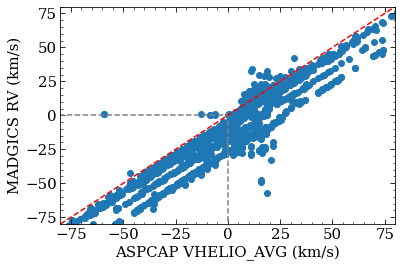

In [14]:
fig, ax = plt.subplots()
mrvelos_km_s = 3e5 * (np.power(10, 6e-6 * mrvelos) - 1)
ax.scatter(arvelos, mrvelos_km_s)
ax.set_xlabel('ASPCAP VHELIO_AVG (km/s)')
ax.set_ylabel('MADGICS RV (km/s)')
ax.set_xlim(-80, 80)
ax.set_ylim(-80, 80)

plt.plot((-100, 0, 0), (0, 0, -80), linestyle = 'dashed', color = 'grey')
plt.plot((-80, 80), (-80, 80), color = 'r', linestyle = 'dashed')

plt.show()

In [15]:
mrvelos_v = np.zeros(len(CA_visit))
arvelos_v = np.zeros(len(CA_visit))

for i in range(len(CA_visit)):
    star = CA_visit[i]
    val = CAvidx[i]

    mrvelos_v[i] = getoutputsdata('RV_pixoff_final', val, version = vers0)
    arvelos_v[i] = (star['VREL'])


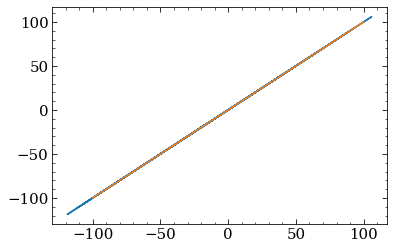

In [16]:
plt.plot(CA_visit['VHELIO'], CA_visit['VREL'] + CA_visit['BC'])
plt.plot((-100, 100), (-100, 100))

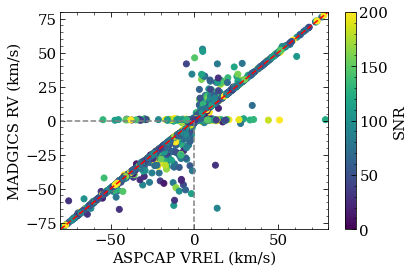

In [17]:
# fig, ax = plt.subplots()

# ax.scatter(arvelos_v, mrvelos_v)
# ax.set_xlabel('ASPCAP VREL (km/s)')
# ax.set_ylabel('MADGICS RV_PIXOFF (pix)')
# ax.set_xlim(-80, 80)
# ax.set_ylim(-20, 20)

# plt.plot((-100, 0, 0), (0, 0, -40), linestyle = 'dashed', color = 'grey')

# plt.show()

fig, ax = plt.subplots()
mrvelos_km_s_v = 3e5 * (np.power(10, 6e-6 * mrvelos_v) - 1)
points = ax.scatter(arvelos_v, mrvelos_km_s_v, c = CA_visit['SNR'], vmin = 0, vmax= 200)
ax.set_xlabel('ASPCAP VREL (km/s)')
ax.set_ylabel('MADGICS RV (km/s)')
ax.set_xlim(-80, 80)
ax.set_ylim(-80, 80)

plt.plot((-100, 0, 0), (0, 0, -80), linestyle = 'dashed', color = 'grey')
plt.plot((-80, 80), (-80, 80), color = 'r', linestyle = 'dashed')

fig.colorbar(points, label = 'SNR', cmap = 'viridis')
plt.show()

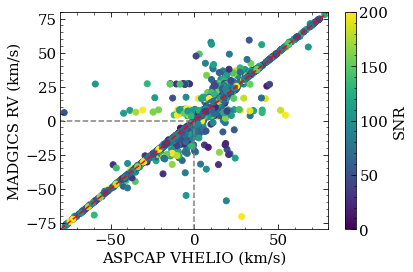

In [ ]:


fig, ax = plt.subplots()
mrvelos_km_s_v = 3e5 * (np.power(10, 6e-6 * mrvelos_v) - 1)
points = ax.scatter(CA_visit['VHELIO'], mrvelos_km_s_v + CA_visit['BC'] , c = CA_visit['SNR'], vmin = 0, vmax= 200)
ax.set_xlabel('ASPCAP VHELIO (km/s)')
ax.set_ylabel('MADGICS RV (km/s)')
ax.set_xlim(-80, 80)
ax.set_ylim(-80, 80)

plt.plot((-100, 0, 0), (0, 0, -80), linestyle = 'dashed', color = 'grey')
plt.plot((-80, 80), (-80, 80), color = 'r', linestyle = 'dashed')

fig.colorbar(points, label = 'SNR', cmap = 'viridis')
plt.show()

In [20]:
v1 = CA_meta['ALLSTAR_IDX'][0]
match = np.where(idx0 == v1)[0]
midx = match[0]
fluxerr = getoutputsdata('fluxerr2', midx, version = vers1)
print(fluxerr.shape)

(8700,)


In [31]:
mrespath = '/uufs/astro.utah.edu/common/home/u1371365/Data/230829_MADGICSResiduals/'

mwindow_fit = ((mwavs > lambda0-25) & (mwavs < lambda0 - 8)) | ((mwavs > lambda0 + 8) & (mwavs < lambda0 + 25))
mwavs_fit = mwavs[mwindow_fit]
def continuum_shift(data):
    data_fit = np.copy(data[mwindow_fit])
    offset = np.nanmedian(data_fit) - 1
    if np.abs(offset) < 0.02: 
        return offset
    else:
        return 0.0

if True:
    MADGICS_IDX = []
    CA_BUILD_IDX = []
    NMADGICS = np.zeros(len(CA_meta))
    for i in tqdm.tqdm(range(len(CA_meta))):
        v1 = CA_meta['ALLSTAR_IDX'][i]
        match = np.where(idx0 == v1)[0]
        # match = idx0[match]

        if len(match) < 1:
            mres = np.zeros((1, 8700))
            mres[...] = np.nan
            merr = np.zeros((1, 8700))
            merr[...] = np.nan
            mdib = np.zeros((1, 8700))
            mdib[...] = np.nan
            vel = np.nan
            tab = Table([])
            tabvel = np.zeros(len(match))
            tabvelpx = np.zeros(len(match))
            # tab['MADGICS_VRELPX'] = tabvelpx 
            # tab['MADGICS_VBARY'] = tabvel
            # print('nan')
        else: 
            mres = np.zeros((len(match), 8700))
            mres_0 = np.zeros((len(match), 8700))
            merr = np.zeros((len(match), 8700))
            mdib = np.zeros((len(match), 8700))

            tab = allVisit[idxv0[match]]['APOGEE_ID', 'VISIT_ID', 'FIBERID', 'VREL', 'VHELIO', 'BC', 'GLON', 'GLAT', 'SNR']
            tabvel = np.zeros(len(match))
            tabvelpx = np.zeros(len(match))

            for j in range(len(match)):
                tabj = tab[j]
                if tabj['APOGEE_ID'] != CA_meta['APOGEE_ID'][i]:
                    print('mismatch')
                midx = match[j]

                flux = getoutputsdata('flux', midx, version = vers1)
                fluxerr = getoutputsdata('fluxerr2', midx, version = vers1)
                skylines = getoutputsdata('x_skyLines_v1_1_15273', midx, version = vers0)
                skycont = getoutputsdata('x_skyContinuum_v1_1_15273', midx, version = vers0)
                starcont = getoutputsdata('x_starContinuum_v1_1_15273', midx, version = vers0)
                starlines = getoutputsdata('x_starLines_v1_1_15273', midx, version = vers0)
                dib = getoutputsdata('x_dib_v1_1_15273', midx, version = vers0)

                skylines_0 = getoutputsdata('x_skyLines_v0', midx, version = vers0)
                skycont_0 = getoutputsdata('x_skyContinuum_v0', midx, version = vers0)
                starcont_0 = getoutputsdata('x_starContinuum_v0', midx, version = vers0)
                starlines_0 = getoutputsdata('x_starLines_v0', midx, version = vers0)

                vrelpx = getoutputsdata('RV_pixoff_final', midx, version = vers0)

                barycorr = tabj['BC']
                vrel = 3e5 * (10**(6e-6 * vrelpx) - 1)
                vbary = vrel + barycorr

                tabvelpx[j] = vrelpx
                tabvel[j] = vbary

                # print(velocity)

                res = (flux - skylines - skycont) / (starcont * (1 + starlines))
                res_0 = (flux - skylines_0 - skycont_0) / (starcont_0 * (1 + starlines_0))

                mres[j, :] = resample_interp_v2(res, rv = barycorr)
                merr[j, :] = resample_interp_v2(fluxerr, rv = barycorr)
                mdib[j, :] = resample_interp_v2(dib, rv = barycorr)
                mres_0[j, :] = resample_interp_v2(res_0, rv = barycorr)
                # mres[j, :] = res #resample_interp(res, vbary, resample_wavelengths = mwavs, hdu_sel = mhdul)
                # mdib[j, :] = dib # resample_interp(dib, vbary, resample_wavelengths = mwavs, hdu_sel = mhdul)

                # mres[j, :] = resample_interp_madgics(res, velocity, resample_wavelengths = mwavs, hdu_sel = mhdul)
                # mdib[j, :] = resample_interp_madgics(dib, velocity, resample_wavelengths = mwavs, hdu_sel = mhdul)

            med_mres = np.median(mres, axis = 0)
            contshift = continuum_shift(med_mres)
            med_mres = med_mres - contshift
            mres = np.vstack([med_mres, mres])

            medmean_merr = np.max([np.nanmedian(merr, axis = 0), np.nanmean(merr, axis = 0)], axis = 0)
            merr = np.vstack([medmean_merr, merr])

            med_mres_0 = np.median(mres_0, axis = 0)
            contshift_0 = continuum_shift(med_mres_0)
            med_mres_0 = med_mres_0 - contshift_0
            mres_0 = np.vstack([med_mres_0, mres_0])
            
            med_mdib = np.median(mdib, axis = 0)
            mdib = np.vstack([med_mdib, mdib])
            tab['MADGICS_VRELPX'] = tabvelpx 
            tab['MADGICS_VBARY'] = tabvel


        # print('VHELIO', CA_meta['VHELIO_AVG'][i])
        primHDU = fits.PrimaryHDU()
        mresHDU = fits.ImageHDU(mres)
        mresHDU.header['DESC'] = 'MADGICS stellar residual - median : visit'
        mdibHDU = fits.ImageHDU(mdib)
        mdibHDU.header['DESC'] = 'MADGICS dib - median : visit'
        mtabHDU = fits.BinTableHDU(tab)
        mres0HDU = fits.ImageHDU(mres_0)
        mres0HDU.header['DESC'] = 'MADGICS 0th run stellar residual - median : visit'
        merrHDU = fits.ImageHDU(merr)
        merrHDU.header['DESC'] = 'MADGICS FLUX ERR - median/mean : visit'


        hdul = fits.HDUList([primHDU, mresHDU, mdibHDU, mtabHDU, mres0HDU, merrHDU])
        for hdu in hdul:
            hdu.header['NVISIT'] = len(match)
            # hdu.header['MADGICS_INDS'] = str(list(match)).rstrip()
            hdu.header['CRVAL1'] = 4.179 - 125 * 6e-6
            hdu.header['CDELT1'] = 6e-6
            # hdu.header['RVELO'] 

        hdul.writeto(mrespath + 'res_{}.fits'.format(CA_meta['APOGEE_ID'][i]), overwrite = True)
            

        # CA_BUILD_IDX = np.concatenate([CA_BUILD_IDX, np.repeat(i, len(match))]).astype(int)
        # MADGICS_IDX = np.concatenate([MADGICS_IDX, match]).astype(int)

  0%|          | 0/1476 [00:00<?, ?it/s]/uufs/chpc.utah.edu/sys/installdir/r8/python/3.10.3/lib/python3.10/site-packages/numpy-1.22.3-py3.10-linux-x86_64.egg/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_43256/2663298643.py:90: RuntimeWarning: Mean of empty slice
  medmean_merr = np.max([np.nanmedian(merr, axis = 0), np.nanmean(merr, axis = 0)], axis = 0)
100%|██████████| 1476/1476 [03:52<00:00,  6.35it/s]


In [30]:
a = np.arange(5)
b = np.arange(4, -1, -1)
np.nanmax([a, b], axis = 0)

array([4, 3, 2, 3, 4])

In [20]:
fails = []
import matplotlib
# matplotlib.use('Agg')
if True:
    with PdfPages('ASPCAP_MADGICS_compare_runs.pdf') as pdf:
        for i in range(0, len(CA_meta), 4):
            fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (18, 16))
            for j in range(4):
                star = CA_meta[i+j]
                hdul = fits.open(get_ca_res(star['FILE']))
                res = hdul[1].data

                mhdul = fits.open(get_madgics_res('res_{}.fits'.format(star['APOGEE_ID'])))
                mres = mhdul[1].data
                mdib = mhdul[4].data # changed from 2 to 4 to be median residual 0
                if mres.ndim != 2:
                    mres = mres[np.newaxis, :]
                    mdib = mdib[np.newaxis, :]
                mres = mres[0,:]
                mdib = mdib[0,:]


                k, l = (int(j // 2), int(j % 2))

                axs[k, l].plot(mwavs, mres, label = 'MADGICS', color = 'k')
                axs[k, l].plot(mwavs, mdib, label = 'MADGICS 0', linestyle = 'dotted', color = 'grey')
                axs[k, l].plot(wavs, res, label = 'ASPCAP {}'.format(star['APOGEE_ID']), color = 'r')
                axs[k, l].set_xlim(lambda0-10, lambda0+10)
                axs[k, l].set_ylim(0.89, 1.05)
                axs[k, l].set_xlabel('Wavelength ($\AA$)')
                axs[k, l].legend()
            pdf.savefig()
            plt.close()



In [149]:
pixvelos = np.zeros(len(CAvidx))
for i in range(len(CAvidx)):
    
    pixvelos[i] = getoutputsdata('RV_pixoff_final', CAvidx[i])

In [150]:
CA_visit['MRV_PIX'] = pixvelos
CA_visit['MRV_KM_S'] = 3e5* (np.power(10, 6e-6*pixvelos)-1)
CA_visit['MVHELIO_KM_S'] = CA_visit['MRV_KM_S'] + CA_visit['BC']

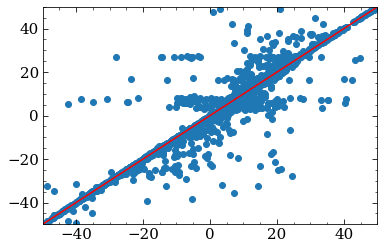

In [151]:
fig, ax = plt.subplots()
ax.scatter(CA_visit['VHELIO'], CA_visit['MVHELIO_KM_S'])
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.plot((-100, 100), (-100, 100), color = 'r')
plt.show()

In [152]:
CA_meta_sort = CA_meta[np.argsort(CA_meta['VHELIO_AVG'])]
madgicsres = np.zeros((len(CA_meta_sort), np.sum(mwindow).astype(int)))
madgicsdib = np.zeros((len(CA_meta_sort), np.sum(mwindow).astype(int)))

aspcapres = np.zeros((len(CA_meta_sort), np.sum(window)))

for i in range(len(CA_meta_sort)): 
    star = CA_meta_sort[i]
    mhdul = fits.open(get_madgics_res('res_{}.fits'.format(star['APOGEE_ID'])))
    ahdul = fits.open(get_ca_res(star['FILE']))
    ares = ahdul[1].data
    mres = mhdul[1].data
    mdib = mhdul[2].data
    if mres.ndim != 2:
        mres = mres[np.newaxis, :]
        mdib = mdib[np.newaxis, :]


    # mres = mres[0,:]
    # mdib = mdib[0,:]
    # print(mdib[window, :].shape)
    madgicsdib[i, :] = mdib[0, mwindow]
    madgicsres[i, :] = mres[0, mwindow]
    aspcapres[i, :] = ares[window]
    

    

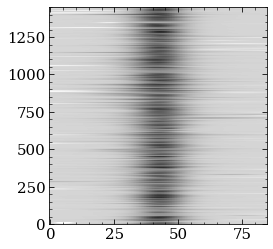

In [153]:
fig, ax = plt.subplots()
madgicsdib = madgicsdib[np.all(np.isnan(madgicsdib)==False,axis = 1)]
h,w = madgicsdib.shape
aspect = w/h
ax.imshow(madgicsdib+1, origin = 'lower', aspect = aspect, cmap = 'binary_r', vmin = 0.95, vmax = 1.01,)
plt.show()

/tmp/ipykernel_2201993/2566414696.py:1: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(np.abs(madgicsres ) * mwavs_window  ,axis = 1) / np.nansum(np.abs(madgicsres), axis = 1)
/tmp/ipykernel_2201993/2566414696.py:3: RuntimeWarning: invalid value encountered in true_divide
  ax.scatter(np.nansum(np.abs(aspcapres ) * mwavs_window  ,axis = 1) / np.nansum(np.abs(aspcapres), axis = 1), np.arange(len(aspcapres)))


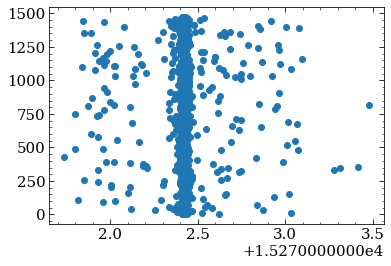

In [154]:
np.nansum(np.abs(madgicsres ) * mwavs_window  ,axis = 1) / np.nansum(np.abs(madgicsres), axis = 1)
fig, ax = plt.subplots()
ax.scatter(np.nansum(np.abs(aspcapres ) * mwavs_window  ,axis = 1) / np.nansum(np.abs(aspcapres), axis = 1), np.arange(len(aspcapres)))
# ax.set_xlim(15270, 15274)
plt.show()


/tmp/ipykernel_2201993/1530334044.py:1: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(np.abs(madgicsres ) * mwavs_window  ,axis = 1) / np.nansum(np.abs(madgicsres), axis = 1)
/tmp/ipykernel_2201993/1530334044.py:3: RuntimeWarning: invalid value encountered in true_divide
  ax.scatter(np.nansum(np.abs(aspcapres ) * mwavs_window  ,axis = 1) / np.nansum(np.abs(aspcapres), axis = 1), np.arange(len(aspcapres)))
/tmp/ipykernel_2201993/1530334044.py:5: RuntimeWarning: invalid value encountered in true_divide
  ax.scatter(np.nansum(np.abs(madgicsres ) * mwavs_window  ,axis = 1) / np.nansum(np.abs(madgicsres), axis = 1), np.arange(len(madgicsres)))


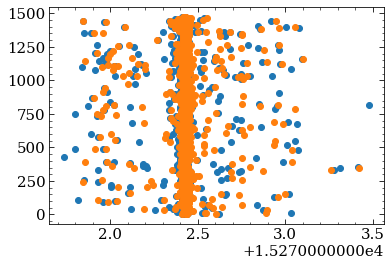

In [155]:
np.nansum(np.abs(madgicsres ) * mwavs_window  ,axis = 1) / np.nansum(np.abs(madgicsres), axis = 1)
fig, ax = plt.subplots()
ax.scatter(np.nansum(np.abs(aspcapres ) * mwavs_window  ,axis = 1) / np.nansum(np.abs(aspcapres), axis = 1), np.arange(len(aspcapres)))
# ax.scatter(np.nansum(np.abs(madgicsdib ) * mwavs_window  ,axis = 1) / np.nansum(np.abs(madgicsdib), axis = 1), np.arange(len(madgicsdib)))
ax.scatter(np.nansum(np.abs(madgicsres ) * mwavs_window  ,axis = 1) / np.nansum(np.abs(madgicsres), axis = 1), np.arange(len(madgicsres)))
# ax.set_xlim(15270, 15274)
plt.show()

/tmp/ipykernel_2201993/2372476663.py:4: RuntimeWarning: invalid value encountered in true_divide
  ax.hist(np.nansum(np.abs(aspcapres ) * mwavs_window  ,axis = 1) / np.nansum(np.abs(aspcapres), axis = 1) - lambda0,


[-0.1   -0.075 -0.05  -0.025  0.     0.025  0.05   0.075  0.1  ]


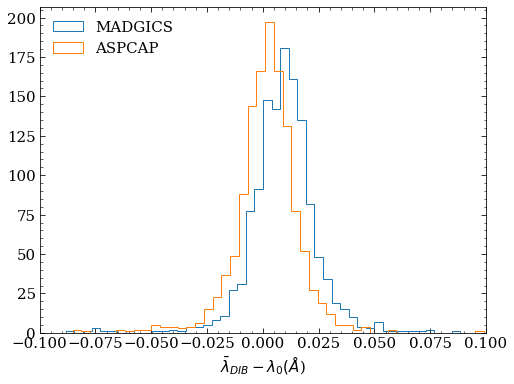

In [161]:
fig, ax= plt.subplots(figsize = (8, 6))
ax.hist(np.nansum(np.abs(madgicsres ) * mwavs_window  ,axis = 1) / np.nansum(np.abs(madgicsres), axis = 1) - lambda0, 
        bins = 50, histtype = 'step', label = 'MADGICS')
ax.hist(np.nansum(np.abs(aspcapres ) * mwavs_window  ,axis = 1) / np.nansum(np.abs(aspcapres), axis = 1) - lambda0, 
        bins = 50, histtype = 'step', label = 'ASPCAP')
ax.set_xlabel(r'$\bar{\lambda}_{DIB} - \lambda_0 (\AA$)')
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax)
ax.set_xlim(-0.1, 0.1)
# ax.plot((lambda0/1e4, lambda0/1e4), (ymin, ymax), linestyle = 'dashed', color = 'k')
ax.legend(loc = 'upper left')
print(ax.get_xticks())


plt.show()

/tmp/ipykernel_2201993/2546474301.py:2: RuntimeWarning: invalid value encountered in true_divide
  ax.scatter(np.nansum(np.abs(madgicsdib ) * mwavs_window  ,axis = 1) / np.nansum(np.abs(madgicsdib), axis = 1), np.arange(len(madgicsdib)))


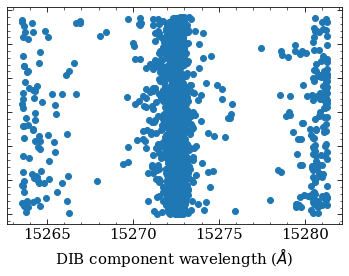

In [157]:
fig, ax = plt.subplots()
ax.scatter(np.nansum(np.abs(madgicsdib ) * mwavs_window  ,axis = 1) / np.nansum(np.abs(madgicsdib), axis = 1), np.arange(len(madgicsdib)))
ax.set_xlabel('DIB component wavelength ($\AA$)')
ax.set_ylabel('')
ax.set_yticklabels('')
plt.show()

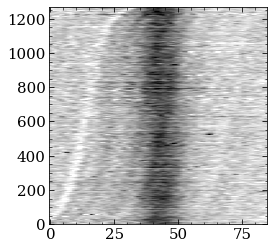

In [158]:
plt.close()
fig, ax = plt.subplots()
madgicsres = madgicsres[np.all(np.isnan(madgicsres)==False,axis = 1)]
h,w = madgicsres.shape
aspect = w/h
ax.imshow(madgicsres , origin = 'lower', aspect = aspect, cmap = 'binary_r', vmin = 0.95, vmax = 1.01,)
plt.show()

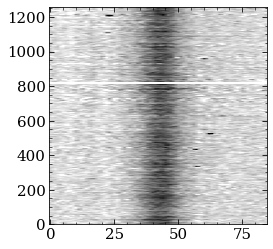

In [159]:
fig, ax = plt.subplots()
aspcapres = aspcapres[np.all(np.isnan(aspcapres)==False,axis = 1)]
h,w = aspcapres.shape
aspect = w/h
ax.imshow(aspcapres , origin = 'lower', aspect = aspect , cmap = 'binary_r', vmin = 0.95, vmax = 1.01,)#extent = (lambda0-9, lambda0+0, 0, len(CA_meta)))